In [1]:
import sys
sys.path.append('..')
import itertools, copy
import re
import json
import numpy as np
import scipy.misc
from scipy.stats import binom
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('../peptidome.mplstyle')

from lib import *
from lib.maxent import *

%load_ext autoreload
%autoreload 2

In [2]:
humanseqs = [s for s in fasta_iter(human, returnheader=False)]


In [3]:
train, test = train_test_split(humanseqs, test_size=0.5)


In [69]:
k = 4
aacountss = []
#for seq in np.random.choice(humanseqs, 1000, replace=False):
for seq in train:
    if not isvalidaa(seq):
        continue
    #seq = re.sub('X|U', '', seq)
    seq = map_aatonumber(seq)
    for i in range(len(seq)-k):
        #if isvalidaa(seq[i:i+k]):
        #print(seq[i:i+k], aacounts(seq[i:i+k]))
        aacountss.append(aacounts_int(seq[i:i+k]))

A 0.07059522858476326 [7.54794807e-01 2.11722090e-01 3.01845351e-02 2.90436611e-03
 3.94201639e-04]
C 0.023177502701475405 [9.12735800e-01 8.19829564e-02 5.12651339e-03 1.44726890e-04
 1.00035170e-05]
D 0.04724205114513125 [8.26366731e-01 1.59172967e-01 1.36403648e-02 7.65085098e-04
 5.48529102e-05]
E 0.07124812893921365 [7.55312503e-01 2.08725414e-01 3.21023722e-02 3.37633590e-03
 4.83374847e-04]
F 0.03636769287693466 [8.63740115e-01 1.27351972e-01 8.60952428e-03 2.93640890e-04
 4.74772873e-06]
G 0.06609005408556985 [7.66992441e-01 2.04481891e-01 2.59688673e-02 2.28646061e-03
 2.70340229e-04]
H 0.026335355760834983 [8.99828285e-01 9.52813270e-02 4.65682112e-03 1.87649160e-04
 4.59180701e-05]
I 0.04285189082255196 [8.41324178e-01 1.46401401e-01 1.18241396e-02 4.43080470e-04
 7.20042992e-06]
K 0.056968369962676894 [7.98261403e-01 1.77640580e-01 2.21820719e-02 1.79486921e-03
 1.21075842e-04]
L 0.10020647366008922 [6.59910836e-01 2.84581506e-01 5.06085283e-02 4.56904945e-03
 3.30081022e-0

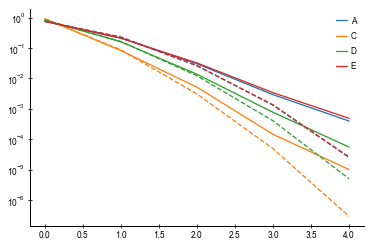

In [70]:
aafreqs = np.mean(np.asarray(aacountss), axis=0)/4
prob_aa_ks = prob_aa(aacountss, k, pseudocount=0.1)
for i in range(len(aminoacids)):
    aa = map_numbertoaa([i])[0]
    prob_aa_k = prob_aa_ks[i]
    print(aa, aafreqs[i], prob_aa_k)
    if i < 4:
        l, = plt.plot(prob_aa_k, label=aa)
        x = np.arange(0, k+1, 1)
        n = k
        p = aafreqs[i]
        plt.plot(x, binom.pmf(x, n, p), '--', c=l.get_color())
plt.legend()
plt.yscale('log')
fks = np.asarray(prob_aa_ks)

In [71]:
df4 = count(train, k)

kmers = [''.join(s) for s in itertools.product(aminoacids, repeat=k)]
df4_test = pd.DataFrame.from_dict(dict(seq=kmers, count=np.ones(len(kmers))))
df4_test.set_index('seq', inplace=True)
df4_count = counter_to_df(count_kmers_iterable(test, k), norm=False)
df4_count.set_index('seq', inplace=True)
df4_test = df4_test.add(df4_count, fill_value=0.0)
df4_test['freq'] = df4_test['count'] / np.sum(df4_test['count'])

m, jsd_test = calc_logfold(df4, df4_test)
jsd_flat = calc_jsd(df4_test['freq'], np.ones_like(df4_test['freq']))

tripletparams = calc_tripletmodelparams(human)
kmers = df4_test.index
df4_test['freq_ind'] = np.array([10**(loglikelihood_independent(s, **tripletparams)) for s in kmers])
df4_test['freq_mc'] = np.array([10**(loglikelihood_mc(s, **tripletparams)) for s in kmers])
df4_test['freq_tri'] = np.array([10**(loglikelihood_triplet(s, **tripletparams)) for s in kmers])
jsd_ind = calc_jsd(df4_test['freq'], df4_test['freq_ind'])
jsd_mc = calc_jsd(df4_test['freq'], df4_test['freq_mc'])
jsd_tri = calc_jsd(df4_test['freq'], df4_test['freq_tri'])


In [72]:
# evaluate empirical observables for fitting
df0 = count(train, 1)
df1 = count(train, 2, gap=0)
dfgap1 = count(train, 2, gap=1)

In [73]:
h, Jk = fit_ising(df0, [df1, dfgap1], nmcmc=1e5, niter=10, epsilon=0.2, N=k, output=True)

[ 0.46194083 -0.65322325  0.05843359  0.46901279 -0.20296285  0.39351318
 -0.52609079 -0.04018499  0.24680762  0.80977978 -0.73906536 -0.22387334
  0.35362185  0.07673691  0.24060859  0.62937441  0.18502876  0.28728595
 -1.30310526 -0.52363841]
iteration 0
f1 2.5119810537676278e-05
f2, gap 0 0.0028177271767545744
f2, gap 1 0.002640604801964144
iteration 1
f1 3.15578267264995e-05
f2, gap 0 0.0019803909484722732
f2, gap 1 0.0018447478609911736
iteration 2
f1 3.908936238452032e-05
f2, gap 0 0.001378112431078382
f2, gap 1 0.0013344285489743579
iteration 3
f1 2.526738441587195e-05
f2, gap 0 0.0012260181296563691
f2, gap 1 0.0012713514655230099
iteration 4
f1 1.9142523785764748e-05
f2, gap 0 0.000981440894575134
f2, gap 1 0.0012012382877789603
iteration 5
f1 4.0983362295054644e-05
f2, gap 0 0.0007728108201046737
f2, gap 1 0.0011541717432224073
iteration 6
f1 3.775671377873266e-05
f2, gap 0 0.000860857245134716
f2, gap 1 0.0009447488089724243
iteration 7
f1 6.206889594268811e-05
f2, gap 0 0.0

In [74]:
q = naminoacids
Z = np.exp(scipy.special.logsumexp([-clib.energy(np.array(s), h, Jk) for s in itertools.product(range(q), repeat=k)]))
df4_test['freq_maxent'] = np.exp([-clib.energy(map_aatonumber(s), h, Jk) for s in kmers])/Z
jsd_maxent = calc_jsd(df4_test['freq'], df4_test['freq_maxent'])

In [75]:
hks = fit_global(fks, niter=3, nmcmc=2e5, epsilon=0.1)

In [77]:
niter=20
nmcmc=2e5
epsilon=0.2
prng=None
output=False

N = len(fks[0])-1
if prng is None:
    prng = np.random
q = len(aminoacids)
aas_arr = np.array(list(aminoacids))
hks = np.zeros((q, N+1))
for i in range(niter):
    if output:
        print('iteration %g'%i)
    def jump(x):
        return prng.randint(q, size=N)
    def energy(x):
        return energy_global(aacounts_int(x), hks)
    x0 = jump(None)
    samples = mcmcsampler(x0, energy, jump, nmcmc, prng=prng)
    aacountss = [aacounts_int(s) for s in samples]
    prob_aa_ks = prob_aa(aacountss, N, pseudocount=0.1)
    hks += np.log(fks/prob_aa_ks)*epsilon
    jsd = calc_jsd(fks, prob_aa_ks)
    print(hks, jsd)


[[-0.01521036  0.04188077  0.16255634  0.37495414  0.85442239]
 [ 0.02282658 -0.14785438 -0.19395675 -0.23999626  0.11963723]
 [ 0.00303592 -0.01490778 -0.00684852  0.09723772  0.45998093]
 [-0.01544125  0.04117848  0.1706643   0.3837953   0.89520837]
 [ 0.01198827 -0.06031242 -0.09595548 -0.07418198  0.4501622 ]
 [-0.01178548  0.03396319  0.1326195   0.30184196  0.51585078]
 [ 0.01980254 -0.11722417 -0.20951794 -0.19012155  0.21720324]
 [ 0.00628111 -0.03048358 -0.02945833 -0.01621567  0.53345708]
 [-0.00394478  0.00653971  0.09990448  0.27646537  1.09791237]
 [-0.04223325  0.10188769  0.26346505  0.49450335  0.81891751]
 [ 0.02523977 -0.16881934 -0.3191992  -0.42358756 -0.27095078]
 [ 0.01227494 -0.06256257 -0.10079291 -0.09956597 -0.22938807]
 [-0.00813835  0.01683081  0.14363418  0.37346677  0.86724619]
 [ 0.00224887 -0.01325176  0.01535293  0.11376824  1.21322561]
 [-0.00423966  0.00874654  0.0961237   0.27964766  0.40011007]
 [-0.025834    0.06658461  0.21879639  0.44535663  1.31

[[-5.52551222e-02  1.36289944e-01  5.44224518e-01  1.31576427e+00
   5.07502540e+00]
 [ 8.11116098e-02 -6.04981230e-01 -8.20991503e-01 -1.03710616e+00
   2.40954827e-01]
 [ 1.64708750e-02 -7.89897432e-02 -5.33565441e-02  2.98506599e-01
   2.59492015e+00]
 [-5.64976128e-02  1.29073953e-01  6.10911352e-01  1.36686190e+00
   3.25308735e+00]
 [ 4.81354436e-02 -2.55732214e-01 -4.14462804e-01 -5.03402315e-01
   6.75119536e-02]
 [-4.24787522e-02  1.13110319e-01  4.43475015e-01  1.13069918e+00
   4.25373345e+00]
 [ 7.31066014e-02 -4.85152013e-01 -8.95423630e-01 -8.01948215e-01
   4.24781390e+00]
 [ 2.96753592e-02 -1.44679750e-01 -1.70738586e-01 -1.08485447e-01
   1.28209594e+00]
 [-1.03994380e-02  4.83135959e-03  3.29156698e-01  9.53050346e-01
   3.47752673e+00]
 [-1.71291922e-01  3.46801227e-01  9.38506010e-01  1.61792372e+00
   6.60448172e+00]
 [ 8.61851406e-02 -6.88637486e-01 -1.29750448e+00 -1.92185369e+00
  -5.87243752e-01]
 [ 4.95682365e-02 -2.65789394e-01 -4.64633920e-01 -5.52943766e-01

[[-6.62324745e-02  1.61220761e-01  6.49167761e-01  1.56558344e+00
   4.92446876e+00]
 [ 9.18377811e-02 -7.07584269e-01 -9.63719125e-01 -1.29029006e+00
   3.23703624e+00]
 [ 1.78456227e-02 -8.50108671e-02 -5.77441226e-02  3.50090240e-01
   2.02577117e+00]
 [-6.71530251e-02  1.51041863e-01  6.96979272e-01  1.66615787e+00
   4.92045291e+00]
 [ 5.39592605e-02 -2.89490995e-01 -4.76014144e-01 -6.46435554e-01
   9.44728095e-01]
 [-4.99256756e-02  1.33937554e-01  5.10354090e-01  1.33327894e+00
   5.09326228e+00]
 [ 8.38076532e-02 -5.63218850e-01 -1.04103930e+00 -9.35941623e-01
   4.07909397e+00]
 [ 3.34478532e-02 -1.62820294e-01 -2.01710524e-01 -2.44307893e-01
   3.61963607e-01]
 [-1.27819783e-02  7.25405272e-03  3.92578121e-01  1.09519849e+00
   4.29738836e+00]
 [-1.99237016e-01  4.05088474e-01  1.08476450e+00  1.91908224e+00
   7.25970430e+00]
 [ 9.72928187e-02 -8.08204653e-01 -1.52285206e+00 -2.27606533e+00
   4.55897605e-01]
 [ 5.70719956e-02 -3.11122675e-01 -5.32384031e-01 -6.10194346e-01

[[-7.70826708e-02  1.96415870e-01  7.16222318e-01  1.67620838e+00
   4.34019240e+00]
 [ 9.23683386e-02 -7.11863598e-01 -9.65166619e-01 -1.06648570e+00
   1.20375092e+00]
 [ 1.33697929e-02 -6.27807575e-02 -1.80738351e-02  3.12626385e-01
   2.33229486e+00]
 [-7.88113964e-02  1.81209467e-01  7.72411905e-01  1.83957321e+00
   6.07346507e+00]
 [ 5.20237909e-02 -2.76079041e-01 -4.77663222e-01 -4.99814975e-01
   1.04124931e+00]
 [-5.81342622e-02  1.65723765e-01  5.66096592e-01  1.45380867e+00
   4.62020636e+00]
 [ 8.38731238e-02 -5.59995653e-01 -1.05716849e+00 -1.00715280e+00
   3.45940023e+00]
 [ 3.07200295e-02 -1.50328663e-01 -1.57918510e-01 -9.69783284e-02
   1.54251748e-03]
 [-1.63443958e-02  2.96082622e-02  4.27588828e-01  1.17262486e+00
   6.42765156e+00]
 [-2.03676521e-01  4.49399999e-01  1.17184615e+00  1.92948155e+00
   5.75825307e+00]
 [ 9.84813149e-02 -8.21066398e-01 -1.55292865e+00 -2.25411644e+00
   2.76745493e-01]
 [ 5.51859328e-02 -2.98567287e-01 -5.18018896e-01 -5.75284157e-01

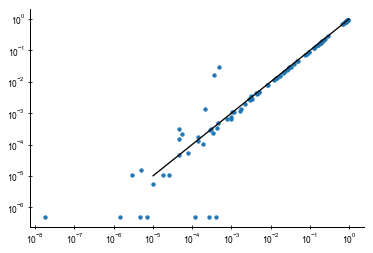

In [78]:
plt.plot(fks.flatten(), prob_aa_ks.flatten(), 'o')
x = [1e-5, 1e0]
plt.plot(x, x, 'k')
plt.xscale('log')
plt.yscale('log')

In [79]:
Z = np.exp(scipy.special.logsumexp([-energy_global(aacounts_int(np.array(s)), hks) for s in itertools.product(range(naminoacids), repeat=k)]))
df4_test['freq_maxentglobal'] = np.exp([-energy_global(aacounts(s), hks) for s in kmers])/Z
jsd_maxentglobal = calc_jsd(df4_test['freq'], df4_test['freq_maxentglobal'])

In [66]:
print('4mer', 'test', jsd_test, 'maxent', jsd_maxent, 'maxentglobal', jsd_maxentglobal,
              'flat', jsd_flat, 'ind', jsd_ind, 'mc', jsd_mc, 'tri', jsd_tri)

4mer test 0.0004890217721554774 maxent 0.0017059608105879332 maxentglobal 0.005131522435989659 flat 0.07943078411823819 ind 0.007212790893547393 mc 0.002810818663798725 tri 0.00012223784358673543


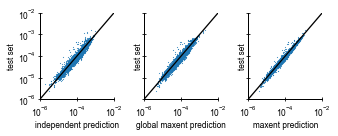

In [68]:
fig, axes = plt.subplots(figsize=(4.8, 2.0), ncols=3, sharex=True, sharey=True)
ax = axes[0]
ax.scatter(df4_test['freq_ind'], df4_test['freq'], s=0.1, alpha=1)
ax.set_xlabel('independent prediction')
ax.set_ylabel('test set')
ax = axes[1]
ax.scatter(df4_test['freq_maxentglobal'], df4_test['freq'], s=0.1, alpha=1)
ax.set_xlabel('global maxent prediction')
ax.set_ylabel('test set')
ax = axes[2]
ax.scatter(df4_test['freq_maxent'], df4_test['freq'], s=0.1, alpha=1)
ax.set_xlabel('maxent prediction')
ax.set_ylabel('test set')
x = np.logspace(-6, -2)
for ax in axes:
    ax.plot(x, x, 'k')
    ax.set_xlim(min(x), max(x))
    ax.set_ylim(min(x), max(x))
    #plt.legend()
    ax.set_xscale('log')
    ax.set_yscale('log')
fig.tight_layout()
fig.savefig('main.png', dpi=300)
fig.savefig('main.pdf')

In [ ]:
hks